## Importing dataset of image information:

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import resnet50
from PIL import Image
from numpy import asarray

import random
import os
import pandas as pd
import numpy as np
from skimage.io import imread_collection
import skimage.io
import skimage.color
import skimage.transform
from platform import python_version
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

print(tf.__version__)
print(python_version())

Using TensorFlow backend.


1.14.0
3.6.6


In [2]:
# extract filenames from the folder of images
filenames = []
for root, dirs, files in os.walk('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg'):
    for file in files:
        if file.endswith('.jpg'):
            filenames.append(file)

print("Total images in Jeremy Howard's metatable: "+"{}".format(len(filenames)))

Total images in Jeremy Howard's metatable: 194082


In [3]:
labels = pd.read_feather('../input/rsna-hemorrhage-jpg/meta/meta/labels.fth')

#manipulate the filenames list, stripping the .jpg at the end
idstosearch = [item.rstrip(".jpg") for item in filenames]

#now search the "ID" column for ids that correspond to our filenames
labels = labels[labels['ID'].isin(idstosearch)]

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_feather(path, columns=columns, nthreads=int_use_threads)
/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


## Cleaning and splitting the dataset of image information:
Get a dataset of only images with 3+ hemorrhages types (6,547) and 20,000 random healthy images.

In [4]:
random.seed(10)
new_hem = labels[labels[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(1) >= 3].copy()
new_normal = labels[labels['any'] == 0].copy()
new_normal = new_normal.sample(n = 20000)
frames = [new_normal, new_hem]
new = pd.concat(frames)
new = new.sort_values('ID')
print("Number of images with hemorrhage: "+"{}".format(len(new_hem)))
print("Number of healthy images: "+"{}".format(len(new_normal)))
print("Percent of dataset with 3+ hemorrhage types: "+"{:.2%}".format(len(new_hem)/len(new)))

Number of images with hemorrhage: 6547
Number of healthy images: 20000
Percent of dataset with 3+ hemorrhage types: 24.66%


## Image import:
Import photos using their ID names drawn from the train and test datasets. These images come from Jeremy Howard's [dataset](https://www.kaggle.com/jhoward/rsna-hemorrhage-jpg) of ~200,000 images.

In [5]:
new, test = train_test_split(new, test_size = 0.1)
newlist = new['ID']
newids = ["../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/"+ x + ".jpg" for x in newlist]
newimages = imread_collection(newids)

labels_new = new.iloc[:, 1]
print("Percent train images hemorrhage positive: "+"{:.2%}".format(labels_new.sum()/len(new)))

testlist = test['ID']
testids = ["../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/"+ x + ".jpg" for x in testlist]
testimages = imread_collection(testids)

labels_test = test.iloc[:, 1]
print("Percent test images hemorrhage positive: "+"{:.2%}".format(labels_test.sum()/len(test)))

Percent train images hemorrhage positive: 24.73%
Percent test images hemorrhage positive: 24.03%


In [6]:
labels_new = pd.Series.to_numpy(labels_new)
newimages_arr = skimage.io.collection.concatenate_images(newimages)
labels_test = pd.Series.to_numpy(labels_test)
testimages_arr = skimage.io.collection.concatenate_images(testimages)

## Model training:
Only ran 5000 training images due to time constraints.

In [7]:
from keras.applications import resnet50

model = resnet50.ResNet50(weights=None, input_shape=(256, 256, 3), include_top=True, classes = 2)

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(newimages_arr, labels_new, epochs=10, validation_split = .1)

Train on 21502 samples, validate on 2390 samples
Epoch 1/10
21502/21502 [==============================] - 208s 10ms/step - loss: 0.2531 - accuracy: 0.9118 - val_loss: 0.2504 - val_accuracy: 0.8987
Epoch 2/10
21502/21502 [==============================] - 188s 9ms/step - loss: 0.1453 - accuracy: 0.9489 - val_loss: 0.5990 - val_accuracy: 0.8502
Epoch 3/10
21502/21502 [==============================] - 188s 9ms/step - loss: 0.1389 - accuracy: 0.9516 - val_loss: 0.1971 - val_accuracy: 0.9510
Epoch 4/10
21502/21502 [==============================] - 188s 9ms/step - loss: 0.1230 - accuracy: 0.9573 - val_loss: 0.2836 - val_accuracy: 0.9490
Epoch 5/10
21502/21502 [==============================] - 189s 9ms/step - loss: 0.1123 - accuracy: 0.9596 - val_loss: 0.1033 - val_accuracy: 0.9674
Epoch 6/10
21502/21502 [==============================] - 189s 9ms/step - loss: 0.1069 - accuracy: 0.9631 - val_loss: 0.1742 - val_accuracy: 0.9402
Epoch 7/10
21502/21502 [==============================] - 189s

## Model summary:

In [10]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

## Model validation:

In [11]:
import sklearn.metrics as metrics
predictions = model.predict(testimages_arr)
predictions = predictions[:,1]

test_loss, test_acc = model.evaluate(testimages_arr, labels_test, verbose=2)
print("Test Accuracy: "+"{:.2%}".format(test_acc))

Test Accuracy: 89.91%


In [12]:
#predictions_clean = np.argmax(predictions,axis=1)
#predictions_clean

In [13]:
mse = metrics.mean_squared_error(predictions.flatten(), labels_test)
print("Test MSE: "+"{:.3}".format(mse))

Test MSE: 0.0694


Test AUC: 0.99


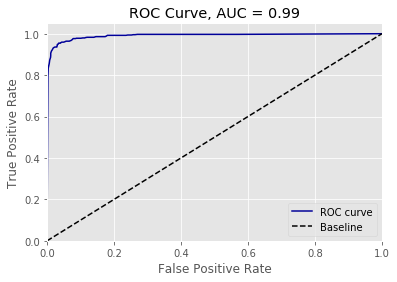

In [14]:
def get_statistics(preds, test, threshold):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(0, len(test)):
        if test[i] == 1 and preds[i] >= threshold:
            tp += 1
        elif test[i] == 1 and preds[i] < threshold:
            fn += 1
        elif test[i] == 0 and preds[i] >= threshold:
            fp += 1
        elif test[i] == 0 and preds[i] < threshold:
            tn += 1

    return (tp, fp, tn, fn)

tpr = []
fpr = []
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    # DNN
    (tp, fp, tn, fn) = (0, 0, 0, 0)
    (tp_s, fp_s, tn_s, fn_s) = get_statistics(preds=predictions.flatten(), test=labels_test, threshold=threshold)

    tp += tp_s
    fp += fp_s
    tn += tn_s
    fn += fn_s

    try:
        #print("Threshold: {} has TPR: {}".format(threshold, float(tp) / (tp + fn)))
        tpr.append(float(tp) / (tp + fn))
    except:
        #print("Threshold: {} has TPR: {}".format(threshold, 0))
        tpr.append(0)

    try:
        #print("Threshold: {} has FPR: {}".format(threshold, float(fp) / (fp + tn)))
        fpr.append(float(fp) / (fp + tn))

    except:
        #print("Threshold: {} has FPR: {}".format(threshold, 0))
        fpr.append(0)

auc = metrics.auc(fpr, tpr)
title = 'ROC Curve, AUC = {:.2}'.format(auc)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "#000099", label='ROC curve')
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title(title)
    
print("Test AUC: "+"{:.3}".format(auc))